In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_dir = os.path.join(os.getcwd(), "ucla-covid19-prediction")

In [4]:
columns = ["Province_State", "Date", "Recovered","Active", "Incident_Rate", "Total_Test_Results", "Case_Fatality_Ratio", "Testing_Rate", "Confirmed", "Deaths"]

In [5]:
# Class dataset
dataset = pd.read_csv(os.path.join(data_dir, "train_trendency.csv"), index_col=0)
dataset = dataset.reindex(columns=columns)

dataset

,Province_State,Date,Recovered,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,Confirmed,Deaths
0,Alabama,01-12-2021,211684.0,190591.0,8318.021857,1981019.0,1.366440,40402.697430,407848,5573
1,Alaska,01-12-2021,7165.0,43132.0,6906.205360,1357708.0,0.445351,185594.597735,50544,225
2,Arizona,01-12-2021,86757.0,538861.0,8739.177523,5742443.0,1.647854,42806.225328,636100,10482
3,Arkansas,01-12-2021,229700.0,25732.0,8600.724235,2208736.0,1.587730,73190.174047,259553,4121
4,California,01-12-2021,NaN,2773506.0,7098.216165,36508384.0,1.110900,92397.696784,2832085,31345
...,...,...,...,...,...,...,...,...,...,...
3945,Virginia,03-31-2021,NaN,NaN,7251.767584,6466133.0,1.656284,75755.592601,618976,10252
3946,Washington,03-31-2021,NaN,NaN,4786.488792,5890924.0,1.439561,77360.561731,364486,5247
3947,West Virginia,03-31-2021,NaN,NaN,7908.837835,2468123.0,1.887991,137718.780881,141738,2676
3948,Wisconsin,03-31-2021,NaN,NaN,10923.970972,7585402.0,1.150083,130278.883367,636041,7315


In [6]:
test_dataset = pd.read_csv(os.path.join(data_dir, "test_data.csv"), index_col=0)
test_dataset

,Province_State,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,Date
0,Alabama,515866,10553,NaN,NaN,10521.038876,2406977.0,2.045686,49090.071046,04-01-2021
1,Alaska,63298,313,NaN,NaN,8637.746140,1904230.0,0.495339,260302.510440,04-01-2021
2,Arizona,842192,16977,NaN,NaN,11570.610590,8533893.0,2.015811,117244.467672,04-01-2021
3,Arkansas,330609,5636,NaN,NaN,10955.284041,2857923.0,1.704733,94702.074754,04-01-2021
4,California,3671349,59411,NaN,NaN,9291.679185,53786487.0,1.618234,136126.198215,04-01-2021
...,...,...,...,...,...,...,...,...,...,...
1495,Virginia,659590,10770,NaN,NaN,7727.591023,7014294.0,1.632833,82177.709405,04-30-2021
1496,Washington,403040,5499,NaN,NaN,5292.786123,6508152.0,1.364381,85466.099130,04-30-2021
1497,West Virginia,153128,2679,NaN,NaN,8544.388379,2738468.0,1.749517,152803.759959,04-30-2021
1498,Wisconsin,660450,7550,NaN,NaN,11343.194272,8255143.0,1.143160,141781.650080,04-30-2021


In [7]:
dataset["Date"] = dataset["Date"].map(lambda date: date[:5])

In [8]:
dataset.isna().sum()

Province_State            0
Date                      0
Recovered              1933
Active                 1250
Incident_Rate             0
Total_Test_Results        0
Case_Fatality_Ratio       0
Testing_Rate              0
Confirmed                 0
Deaths                    0
dtype: int64

Group confirmed case by Date

# Preprocessing

In [9]:
dataset["Date"] = dataset["Date"].map(lambda date: date[:5])

## Add population features

In [10]:
population = pd.read_csv(os.path.join(data_dir, "population.csv"))
population.head()

,rank,State,Pop,Growth,Pop2018,Pop2010,growthSince2010,Percent,density
0,1,California,39613493,0.0038,39461588,37319502,0.0615,0.1184,254.2929
1,2,Texas,29730311,0.0385,28628666,25241971,0.1778,0.0889,113.8081
2,3,Florida,21944577,0.0330,21244317,18845537,0.1644,0.0656,409.2229
3,4,New York,19299981,-0.0118,19530351,19399878,-0.0051,0.0577,409.5400
4,5,Pennsylvania,12804123,0.0003,12800922,12711160,0.0073,0.0383,286.1704


In [11]:
def add_population_column(dataset):
    dataset["population"] = [0] * len(dataset)

    for index, row in population.iterrows():
        subset = dataset[dataset["Province_State"] == row["State"]]
        if len(subset) == 0:
            continue

        dataset.loc[dataset["Province_State"] == row["State"], "population"] = row["Pop"]
    
    return dataset

dataset = add_population_column(dataset)
test_dataset = add_population_column(test_dataset)

## Add Longtitude and Latitude features

In [12]:
coordination = pd.read_csv(os.path.join(data_dir, "coordination.csv"))
coordination.head()

,state,latitude,longitude,name
0,AK,63.588753,-154.493062,Alaska
1,AL,32.318231,-86.902298,Alabama
2,AR,35.201050,-91.831833,Arkansas
3,AZ,34.048928,-111.093731,Arizona
4,CA,36.778261,-119.417932,California


In [13]:
def add_coordination_column(dataset):
    dataset["longitude"] = [0] * len(dataset)
    dataset["latitude"] = [0] * len(dataset)

    for index, row in coordination.iterrows():
        subset = dataset[dataset["Province_State"] == row["name"]]
        if len(subset) == 0:
            continue

        dataset.loc[dataset["Province_State"] == row["name"], "longitude"] = row["longitude"]
        dataset.loc[dataset["Province_State"] == row["name"], "latitude"] = row["latitude"]
    
    return dataset

dataset = add_coordination_column(dataset)
test_dataset = add_coordination_column(test_dataset)

# LSTM Model

In [14]:
from lstm.lstm import LSTMTrainer

# trainer = LSTMTrainer(dataset, val_dataset=None, filename="train_lstm.pth")
# trainer.fit()

# Test on external testset

100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


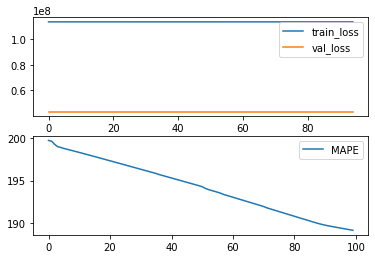

Final performance
[1.13316488e+08 4.34954960e+07]
189.11664


In [15]:
from utils.model import learning_process_with_external_test
from sklearn.linear_model import LinearRegression

test = LSTMTrainer(dataset, val_dataset=test_dataset, filename="lstm_test.pth")
test.fit(save_prediction=True)

In [16]:
test.train_dataset.new_dataset.head()

,Province_State,Date,population,longitude,latitude,Confirmed,Deaths
0,Alabama,01-12,4934193,-86.902298,32.318231,407848,5573
50,Alabama,01-13,4934193,-86.902298,32.318231,410995,5760
100,Alabama,01-14,4934193,-86.902298,32.318231,414583,5945
150,Alabama,01-15,4934193,-86.902298,32.318231,417528,6030
200,Alabama,01-16,4934193,-86.902298,32.318231,420681,6119
